In [1]:
from nltk.corpus import stopwords
import spacy
import nltk
from nltk.tokenize import word_tokenize
sp = spacy.load('en_core_web_sm')

import re 
import string 
import pandas as pd 
import numpy as np 
import math 
from tqdm import tqdm
import json

from pandas.core.frame import DataFrame
from IPython.core.display import display, HTML


import re, nltk, spacy, gensim
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


nlp = spacy.load("en_core_web_sm")
all_stopwords = nlp.Defaults.stop_words
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
df = pd.read_csv('version.csv')
df1 = pd.read_csv('result.csv')
df1

,Unnamed: 0,Unnamed: 0.1,id,speech,display_as,party,constituency,mnis_id,date,time,...,Name_enitity,topic,politics_phase,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,nPn,nVn,verb
0,0,0,uk.org.publicwhip/debate/1979-11-27a.1096.7,Is the Minister aware that in the last two mon...,Robert Maclennan,Labour,Caithness and Sutherland,578.0,1979-11-27,NaN,...,"[('the last two months', 'DATE'), ('300 yards'...",NaN,"[[], [], []]",0,8.0,0.1397,"industry, company, make, market, british, busi...","[['fishermen', 'from', 'constituency'], ['yard...","[['shells', 'vessels', 'Is'], ['they', 'last y...","[been, have, alarmed, landed, entered, appear,..."
1,1,1,uk.org.publicwhip/debate/1979-11-27a.1136.2,Is not the right hon. Gentleman contradicting ...,Roger Moate,Conservative,Faversham,922.0,1979-11-27,16:40:00,...,"[('Gentleman', 'PERSON')]",NaN,"[[], [], [], [], [], []]",1,0.0,0.1437,"local, service, area, authority, constituency,...","[['form', 'of', 'buses']]","[['Gentleman', 'himself', 'contradicting'], ['...","[contradicting, envisages, described, told, co..."
2,2,2,uk.org.publicwhip/debate/1979-11-29a.1477.7,Does the right hon. Gentleman recall that he s...,James Lamond,Labour,Oldham East,894.0,1979-11-29,NaN,...,"[('Gentleman', 'PERSON'), ('earlier this year'...",NaN,"[[], [], [], []]",2,3.0,0.1612,"country, people, government, political, agree,...","[['Friend', 'in', 'manner']]","[['colour', 'British citizens', 'recall'], ['h...","[Does, said, fishing, regarded, reconcile, pre..."
3,3,3,uk.org.publicwhip/debate/1979-11-12a.1080.3,"Question put, That the amendment be made:",Unknown,NaN,NaN,NaN,1979-11-12,00:30:00,...,[],NaN,[[]],3,5.0,0.1214,"bill, make, order, amendment, clause, power, l...",[],[],"[put, made]"
4,4,4,uk.org.publicwhip/debate/1979-11-29a.1470.2,At a most recent census in August 1979 the Uni...,Alick Buchanan-Smith,Conservative,North Angus and Mearns,727.0,1979-11-29,NaN,...,"[('August 1979', 'DATE'), ('United Kingdom', '...",NaN,[[]],4,4.0,0.1172,"case, public, law, police, issue, individual, ...","[['census', 'in', 'August'], ['herd', 'of', 's...","[['breeding herd', 'pig', 'was']]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,uk.org.publicwhip/debate/2021-02-24a.1024.2,"Motion made, and Question put forthwith (Stand...",Unknown,NaN,NaN,NaN,2021-02-24,18:56:00,...,"[('Standing Order No', 'WORK_OF_ART'), ('83A(7...",1.0,"[[], ['Programme ', 'Programme ']]",9995,5.0,0.2410,"bill, make, order, amendment, clause, power, l...","[['Order', 'of', 'January'], ['Order', 'of', '...","[['following provisions', 'January', 'made']]","[made, put, Standing, following, apply, supple..."
9996,9996,9996,uk.org.publicwhip/debate/2021-04-28c.361.4,David Duguid have regular discussions with min...,David Duguid,Conservative,Banff and Buchan,4606.0,2021-04-28,NaN,...,"[('Scotland', 'GPE'), ('State', 'ORG'), ('Unit...",NaN,"[[], []]",9996,3.0,0.1930,"country, people, government, political, agree,...","[['discussions', 'with', 'colleagues'], ['deli...","[['COP26', 'Scotland', 'have'], ['that', 'Unit...","[have, offers, devolved, brings, devolved, sup..."
9997,9997,9997,uk.org.publicwhip/debate/2021-02-22b.655.7,Boris Johnson am really grateful to my hon. Fr...,Boris Johnson,Conservative,Uxbridge and South Ruislip,1423.0,2021-02-22,15:51:00,...,"[('1.3 million', 'CARDINAL'), ('£1.3 billion',...",NaN,"[[], [], [], [], [], []]",9997,9.0,0.1381,"work, important, friend, support, ensure, make...","[['Friend', 'for', 'question'], ['result', 'of...","[['Boris Johnson', 'hon', 'am'], ['who', 'pand...","[support, suffered, distributed, put, focus, f..."
9998,9998,9998,uk.org.publicwhip/debate/2021-02-04b.1186.0,Robert Halfon welcome this debate and thank my...,Robert Halfon,Conservative,Harlow,3985.0,2021-02-04,15:45:00,...,"[('Paul Bristow', 'PERSON'), ('Harlow', 'NORP'...",NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...",9998,0.0,0.2981,"local, service, area, authority, co

In [6]:
from spacy import displacy
text = df1['speech'][8888]
doc = nlp(text)
displacy.render(doc,style='ent',jupyter=True)

In [3]:
def clean(text):
    
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("— ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    #clean hon.
    text = re.sub("hon.","",str(text))
    
    return text

# preprocessing speeches
df1['clean_speech'] = df1['speech'].apply(clean)
    

In [4]:
df1['clean_speech'][2065]

'On many occasions Thomas Jopling have told my  Friend that Thomas Jopling am aware that cutting prices alone will not deal with the cereals surplus. That is why Thomas Jopling proposed last year to the Council of Ministers when it met in the United Kingdom that we should go for a land diversion scheme for cereals. Thomas Jopling am glad about the decision that was taken a few weeks ago in Brussels in agreeing the socio structural package and that we now have a door that is wider open to a scheme of the sort that Thomas Jopling have been proposing to deal with the cereals sector. Thomas Jopling hope that that will be further encouraged in the course of the weeks and months ahead.'

In [5]:
def subtree_matcher(doc):
    subjpass = 0

    for i,tok in enumerate(doc):
        
    # find dependency tag that contains the text "subjpass"    
       if tok.dep_.find("subjpass") == True:
            subjpass = 1

    x = ''
    y = ''
    z = ''

  # if subjpass == 1 then sentence is passive
    if subjpass == 1:
        for i,tok in enumerate(doc):
            if tok.dep_.find("subj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    y = doc[i-1].text + ' '+tok.text
                else:
                    y=tok.text
                                   
            if(tok.dep_.find('ROOT')==0):
                z=tok.lemma_
                
            if tok.dep_.endswith("obj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    x = doc[i-1].text + ' '+tok.text  
                else:
                    x = tok.text
  
  # if subjpass == 0 then sentence is not passive
    else:
        for i,tok in enumerate(doc):
            if tok.dep_.endswith("subj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    x = doc[i-1].text + ' '+tok.text 
                else:
                    x = tok.text
                    
            if(tok.dep_.find('ROOT')==0):
                
                z=tok.lemma_

            if tok.dep_.endswith("obj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    y = doc[i-1].text + ' '+tok.text
                else:
                    y = tok.text
#     if not x and not y and not z:
    return [x,z,y]

In [6]:
def get_relation(text):
    document = nlp(text)
    t = [sent.text for sent in document.sents]
    re =  []
    for i in t:
        i = nlp(i)
        y = subtree_matcher(i)
        if '' not in y:
            re.append(subtree_matcher(i))
    return re

In [141]:
df['nVn'] = df['clean_text'].apply(get_relation)


In [120]:
df1['nVn_1'][0]

[['shells', 'is', 'vessels'],
 ['they', 'is', 'last year'],
 ['he', 'examine', 'this']]

In [69]:
df1['nVerbn_clean'][8]

[['Frank Dobson', 'understand', 'Ravensbourne'],
 ['1945', 'is', 'what'],
 ['original blitz', 'come', '1945'],
 ['we', 'experiencing', 'Government policies'],
 ['regional policy', 'do', 'Whatever'],
 ['Frank Dobson', 'declare', 'interest'],
 ['family', 'live', 'central London'],
 ['Frank Dobson', 'have', 'which'],
 ['which', 'declare', 'Covent Garden'],
 ['we', 'had', 'London'],
 ['That', 'is', 'Labour Government'],
 ['Frank Dobson', 'make', 'them'],
 ['they', 'add', 'Health Service'],
 ['VAT increase', 'taken', 'total'],
 ['That', 'is', 'Health Service'],
 ['loss', 'provided', 'money'],
 ['that', 'is', 'London'],
 ['which', 'faced', 'housing'],
 ['whom', 'was', 'housing'],
 ['GLC', 'afford', 'properties'],
 ['they', 'talking', 'private sector'],
 ['who', 'love', 'years']]

In [ ]:
def rule(text):
    
    doc = nlp(text)
    
    sent = []
    
    for token in doc:

        # look for prepositions
        if token.pos_=='ADP':

            phrase = ''
            
            # if its head word is a noun
            if token.head.pos_=='NOUN':
                
                # append noun and preposition to phrase
                phrase += token.head.text
                phrase += ' '+token.text

                # check the nodes to the right of the preposition
                for right_tok in token.rights:
                    # append if it is a noun or proper noun
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        phrase += ' '+right_tok.text
                phrase = phrase.split()
                if len(phrase)>2:
                    sent.append(phrase)
                
    return sent

In [70]:
def rule0(text, index):
    
    doc = nlp(text)
        
    token = doc[index]
    
    entity = ''
    
    for sub_tok in token.children:
        if (sub_tok.dep_ in ['compound','amod']):
            entity += sub_tok.text+' '
    
    entity += token.text

    return entity

In [74]:
# rule 3 function
def rule3_mod(text):
    
    doc = nlp(text)
    
    sent = []
    
    for token in doc:

        if token.pos_=='ADP':

            
            phrase = []
            if token.head.pos_=='NOUN':
                leftphrase = ''
                
                # appended rule
                append = rule0(text, token.head.i)
                if len(append)!=0:
                    leftphrase += append
                else:  
                    leftphrase += token.head.text
#                 phrase += ' '+token.text
                phrase.append(leftphrase)
                phrase.append(token.text.lower())

                for right_tok in token.rights:
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        
                        right_phrase = ''
                        # appended rule
                        append = rule0(text, right_tok.i)
                        if len(append)!=0:
                            right_phrase += ' '+append
                        else:
                            right_phrase += ' '+right_tok.text
                        phrase.append(right_phrase)
                
                            

                
                if len(phrase)>2:
                    sent.append(phrase)
                

    return sent

In [77]:
text = 'This should give us a fair idea about which sentences we want to explore in detail. For example, efforts against proliferation talk about efforts towards nuclear disarmament. Or the sentence on the struggle against colonialism talks about the historical links between India and Africa borne out of their common struggle against colonialism.'
def getnpn(text):
    document = nlp(text)
    t = [sent.text for sent in document.sents]
    result = []
    for i in t:
        y =rule3_mod(i)
        result+=y
    return result


In [78]:
df1['npnclean'] = df1['clean_speech'].apply(getnpn)

In [80]:
df['clean_text'] = df1['clean_speech']


In [81]:
del df['relation']

In [142]:
df['relation']= df1['npnclean']+df['nVn']

In [143]:
df.to_csv('version.csv')
df1.to_csv('final_re.csv')

In [ ]:
def subtree_matcher(doc):
    subjpass = 0

    for i,tok in enumerate(doc):
        
    # find dependency tag that contains the text "subjpass"    
       if tok.dep_.find("subjpass") == True:
            subjpass = 1

    x = ''
    y = ''
    z = ''

  # if subjpass == 1 then sentence is passive
    if subjpass == 1:
        for i,tok in enumerate(doc):
            if tok.dep_.find("subj") == True:
                for subtoken in tok.children:
                    if (subtoken.pos_ == 'ADJ'):
                        y = subtoken.text + ' 'tok.text
                    else:
                        y=tok.text
                                   
            if(tok.dep_.find('ROOT')==0):
                z=tok.lemma_
                
            if tok.dep_.endswith("obj") == True:
                for subtoken in tok.children:
                    if (subtoken.pos_ == 'ADJ'):
                        x = subtoken.text + ' 'tok.text  
                    else:
                        x = tok.text
  
  # if subjpass == 0 then sentence is not passive
    else:
        for i,tok in enumerate(doc):
            if tok.dep_.endswith("subj") == True:
                for subtoken in tok.children:
                    if (subtoken.pos_ == 'ADJ'):
                        x = subtoken.text + ' 'tok.text
                    else:
                        x = tok.text
                    
            if(tok.dep_.find('ROOT')==0):
                z=tok.text.lower

            if tok.dep_.endswith("obj") == True:
                for subtoken in tok.children:
                    if (subtoken.pos_ == 'ADJ'):
                        y = subtoken.text + ' 'tok.text
                    else:
                        y = tok.text
#     if not x and not y and not z:
    return [x,z,y]

In [115]:
result= []
for i in y:
    i[2] = i[2].lower()
    result.append(i)
print(result)
    

[['alarmed fishermen', 'from', ' constituency'], ['yards', 'of', ' vessels'], ['shells', 'Is', 'vessels'], ['they', 'Is', 'last year'], ['he', 'examine', 'this']]


In [25]:
import json
import requests
from plotly import graph_objs as go
import networkx as nx
gg = nx.Graph()
y=df['relation'][10]
f=eval(y)
for i in f:
    print(i)

['Class V', 'in', ' order']
['Members', 'into', ' subject']
['beginning', 'to', ' subject']
['end', 'of', ' Executive']
['understatements', 'of', ' decade']
['dinosaur', 'in', ' china shop']
['fullness', 'of', ' time']
['series', 'of', ' preliminary movements']
['series', 'in', ' direction']
['sale', 'of', ' Executive dwellings']
['limited movement', 'towards', ' reasonable structure']
['freeze', 'on', ' recruitment']
['freeze', 'to', ' Civil Service']
['effects', 'of', ' policy']
['employee', 'of', ' Housing Executive']
['new public dwelling', 'in', ' England']
['roof', 'over', ' own head']
['sale', 'of', ' council', ' Executive houses']
['Class V', 'concern', 'housing']
['William Ross', 'intend', 'other  ']
['one', 'be', 'subject']
['We', 'seem', 'me']
['report', 'say', 'disturbing reading']
['that', 'think', 'decade']
['it', 'be', 'House']
['china shop', 'be', 'Executive']
['what', 'be', 'it']
['Executive', 'have', 'time']
['William Ross', 'believe', 'direction']
['Executive dwellin

In [94]:

#G 这个图
# for i in range(len(df)):
#     gg.add_node(df['Nouns'][i])
#     for word in df['Verbs & Pres'][i]:
#         gg.add_edges_from([(df['Nouns'][i], word)])
from networkx.drawing.nx_agraph import graphviz_layout

for triple in f:
    print(len(triple))
    gg.add_node(triple[0])
    gg.add_node(triple[1])
    gg.add_node(triple[2])
    gg.add_edge(triple[0], triple[1])
    gg.add_edge(triple[1], triple[2])

pos = nx.spring_layout(gg,0.9)
color_list = []
N = []
for i in gg.nodes:
    doc = nlp(i)
    if doc[0].pos_ == 'prep'or doc[0].pos_=='ADP':
        color_list.append('blue')
        N.append('prep')
#         doc_list.append(i)
    elif doc[0].pos_ == 'AUX' or doc[0].pos_ == 'VERB'or doc[0].pos_ =='INTJ':
        color_list.append('red')
        N.append('Verb')
#         doc_list.append(i)
    else:
        color_list.append('yellow')
        N.append('Noun')
#         doc_list.append(i)
edge_trace = go.Scatter(
    x=[],y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in gg.edges():
    x0,y0=pos.get(edge[0])
    x1,y1=pos.get(edge[1])
    edge_trace['x']+=tuple([x0,x1,None])
    edge_trace['y']+=tuple([y0,y1,None])
node_trace = go.Scatter(
    x=[],y=[],
    hoverinfo='text',
    mode="markers+text",
    name="Entity",
    text= list(pos.keys()),
    marker=dict(size=10, color=color_list))    

for node in gg.nodes():
    x, y=pos.get(node)
    node_trace['x']+=tuple([x])
    node_trace['y']+=tuple([y])

fig = go.Figure(data=[edge_trace, node_trace],
         layout=go.Layout(
            # title='<br>Network graph made with Python',
            titlefont_size=16,
            width=400,
            height=500,
            plot_bgcolor='rgba(0,0,0,0)',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
            )
fig.show()

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [57]:
color_list = []
N = []
doc_list=[]
for i in gg.nodes:
    doc = nlp(i)
    if doc[0].pos_ == 'prep'or doc[0].pos_=='ADP':
        color_list.append('blue')
        N.append('prep')
        doc_list.append(i)
    elif doc[0].pos_ == 'AUX' or doc[0].pos_ == 'VERB'or doc[0].pos_ =='INTJ':
        color_list.append('red')
        N.append('Verb')
        doc_list.append(i)
    else:
        color_list.append('yellow')
        N.append('Noun')
        doc_list.append(i)
print(color_list)
        


['yellow', 'blue', 'yellow', 'yellow', 'blue', 'yellow', 'red', 'blue', 'yellow', 'blue', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'blue', 'yellow', 'red', 'blue', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'blue', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'red', 'yellow', 'yellow', 'red', 'yellow', 'yellow', 'red', 'yellow', 'yellow', 'red', 'red', 'yellow', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'red', 'yellow', 'red', 'yellow', 'yellow', 'red', 'yellow', 'yellow', 'red', 'yellow', 'red', 'yellow', 'yellow', 'yellow', 'red', 'yellow', 'red', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow', 'red', 'yellow', 'yellow', 'red', 'yellow', 'yellow', 'yellow', 'red', 'yellow']


In [58]:
print(N)

['Noun', 'prep', 'Noun', 'Noun', 'prep', 'Noun', 'Verb', 'prep', 'Noun', 'prep', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'prep', 'Noun', 'Verb', 'prep', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'prep', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Verb', 'Noun', 'Noun', 'Verb', 'Noun', 'Noun', 'Verb', 'Noun', 'Noun', 'Verb', 'Verb', 'Noun', 'Verb', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Verb', 'Noun', 'Verb', 'Noun', 'Noun', 'Verb', 'Noun', 'Noun', 'Verb', 'Noun', 'Verb', 'Noun', 'Noun', 'Noun', 'Verb', 'Noun', 'Verb', 'Noun', 'Noun', 'Noun', 'Noun', 'Noun', 'Verb', 'Noun', 'Noun', 'Verb', 'Noun', 'Noun', 'Noun', 'Verb', 'Noun']


In [59]:
print(doc_list)

['Class V', 'in', ' order', 'Members', 'into', ' subject', 'beginning', 'to', 'end', 'of', ' Executive', 'understatements', ' decade', 'dinosaur', ' china shop', 'fullness', ' time', 'series', ' preliminary movements', ' direction', 'sale', ' Executive dwellings', 'limited movement', 'towards', ' reasonable structure', 'freeze', 'on', ' recruitment', ' Civil Service', 'effects', ' policy', 'employee', ' Housing Executive', 'new public dwelling', ' England', 'roof', 'over', ' own head', ' council', 'concern', 'housing', 'William Ross', 'intend', 'other  ', 'one', 'be', 'subject', 'We', 'seem', 'me', 'report', 'say', 'disturbing reading', 'that', 'think', 'decade', 'it', 'House', 'china shop', 'Executive', 'what', 'have', 'time', 'believe', 'direction', 'Executive dwellings', 'see', 'which', 'Civil Service', 'make', 'Government', 'wonder', 'policy', 'structure', 'present stage', 'stop', 'monster', 'work', 'way', 'Ministers', 'hope', 'problem', 'public dwelling', 'understand', '14,500', '

In [55]:
d = nlp('welcome')
print(d[0].pos_)

INTJ


In [38]:
df1

,Unnamed: 0,Unnamed: 0.1,id,speech,display_as,party,constituency,mnis_id,date,time,...,topic,politics_phase,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,nPn,nVn,verb,clean_speech
0,0,0,uk.org.publicwhip/debate/1979-11-27a.1096.7,Is the Minister aware that in the last two mon...,Robert Maclennan,Labour,Caithness and Sutherland,578.0,1979-11-27,NaN,...,NaN,"[[], [], []]",0,8.0,0.1397,"industry, company, make, market, british, busi...","[['fishermen', 'from', 'constituency'], ['yard...","[['shells', 'vessels', 'Is'], ['they', 'last y...","[been, have, alarmed, landed, entered, appear,...",Is the Minister aware that in the last two mon...
1,1,1,uk.org.publicwhip/debate/1979-11-27a.1136.2,Is not the right hon. Gentleman contradicting ...,Roger Moate,Conservative,Faversham,922.0,1979-11-27,16:40:00,...,NaN,"[[], [], [], [], [], []]",1,0.0,0.1437,"local, service, area, authority, constituency,...","[['form', 'of', 'buses']]","[['Gentleman', 'himself', 'contradicting'], ['...","[contradicting, envisages, described, told, co...",Is not the right Gentleman contradicting hims...
2,2,2,uk.org.publicwhip/debate/1979-11-29a.1477.7,Does the right hon. Gentleman recall that he s...,James Lamond,Labour,Oldham East,894.0,1979-11-29,NaN,...,NaN,"[[], [], [], []]",2,3.0,0.1612,"country, people, government, political, agree,...","[['Friend', 'in', 'manner']]","[['colour', 'British citizens', 'recall'], ['h...","[Does, said, fishing, regarded, reconcile, pre...",Does the right Gentleman recall that he said ...
3,3,3,uk.org.publicwhip/debate/1979-11-12a.1080.3,"Question put, That the amendment be made:",Unknown,NaN,NaN,NaN,1979-11-12,00:30:00,...,NaN,[[]],3,5.0,0.1214,"bill, make, order, amendment, clause, power, l...",[],[],"[put, made]","Question put, That the amendment be made:"
4,4,4,uk.org.publicwhip/debate/1979-11-29a.1470.2,At a most recent census in August 1979 the Uni...,Alick Buchanan-Smith,Conservative,North Angus and Mearns,727.0,1979-11-29,NaN,...,NaN,[[]],4,4.0,0.1172,"case, public, law, police, issue, individual, ...","[['census', 'in', 'August'], ['herd', 'of', 's...","[['breeding herd', 'pig', 'was']]",[],At a most recent census in August 1979 the Uni...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,uk.org.publicwhip/debate/2021-02-24a.1024.2,"Motion made, and Question put forthwith (Stand...",Unknown,NaN,NaN,NaN,2021-02-24,18:56:00,...,1.0,"[[], ['Programme ', 'Programme ']]",9995,5.0,0.2410,"bill, make, order, amendment, clause, power, l...","[['Order', 'of', 'January'], ['Order', 'of', '...","[['following provisions', 'January', 'made']]","[made, put, Standing, following, apply, supple...","Motion made, and Question put forthwith ), Tha..."
9996,9996,9996,uk.org.publicwhip/debate/2021-04-28c.361.4,David Duguid have regular discussions with min...,David Duguid,Conservative,Banff and Buchan,4606.0,2021-04-28,NaN,...,NaN,"[[], []]",9996,3.0,0.1930,"country, people, government, political, agree,...","[['discussions', 'with', 'colleagues'], ['deli...","[['COP26', 'Scotland', 'have'], ['that', 'Unit...","[have, offers, devolved, brings, devolved, sup...",David Duguid have regular discussions with min...
9997,9997,9997,uk.org.publicwhip/debate/2021-02-22b.655.7,Boris Johnson am really grateful to my hon. Fr...,Boris Johnson,Conservative,Uxbridge and South Ruislip,1423.0,2021-02-22,15:51:00,...,NaN,"[[], [], [], [], [], []]",9997,9.0,0.1381,"work, important, friend, support, ensure, make...","[['Friend', 'for', 'question'], ['result', 'of...","[['Boris Johnson', 'hon', 'am'], ['who', 'pand...","[support, suffered, distributed, put, focus, f...",Boris Johnson am really grateful to my Friend...
9998,9998,9998,uk.org.publicwhip/debate/2021-02-04b.1186.0,Robert Halfon welcome this debate and thank my...,Robert Halfon,Conservative,Harlow,3985.0,2021-02-04,15:45:00,...,NaN,"[[], [], [], [], [], [], [], [], [], [], [], [...",9998,0.0,0.2981,"local, service, area, authority, cons

In [39]:
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,doc,topic1,topic2,topic3,topic4,topic5,...,Unnamed: 0.1.1.1.1,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,name_entities,clean_text,relation,nVn
0,0,0,0,0,0,0.193974,0.165725,0.171375,0.158192,0.158192,...,0,0,1.0,0.1940,"government, country, state, secretary, communi...","['month', 'episode', 'fisherman', 'constituenc...","[('the last two months', 'DATE'), ('300 yards'...",Is the Minister aware that in the last two mon...,"[['alarmed fishermen', 'from', ' constituency'...","[['shells', 'be', 'vessels'], ['they', 'be', '..."
1,1,1,1,1,1,0.130208,0.131944,0.295139,0.171875,0.131944,...,1,1,3.0,0.2969,"industry, business, policy, company, investmen...","['contradicting', 'competition', 'route', 'com...","[('Gentleman', 'PERSON')]",Is not the right Gentleman contradicting hims...,"[['form', 'of', ' more buses'], ['Gentleman', ...","[['Gentleman', 'contradict', 'himself'], ['he'..."
2,2,2,2,2,2,0.224014,0.139785,0.155914,0.197133,0.146953,...,2,2,1.0,0.2186,"government, country, state, secretary, communi...","['year', 'fishing', 'vote', 'citizen', 'colour...","[('Gentleman', 'PERSON'), ('earlier this year'...",Does the right Gentleman recall that he said ...,"[['Friend', 'in', ' shamefaced manner'], ['col...","[['colour', 'recall', 'British citizens'], ['h..."
3,3,3,3,3,3,0.160256,0.160256,0.160256,0.179487,0.160256,...,3,3,4.0,0.1795,"member, friend, point, debate, question, house...","['question', 'amendment']",[],"Question put, That the amendment be made:",[],[]
4,4,4,4,4,4,0.160256,0.181624,0.177350,0.160256,0.160256,...,4,4,2.0,0.1795,"people, service, child, year, school, area, pr...","['herd', 'gilt']","[('August 1979', 'DATE'), ('United Kingdom', '...",At a most recent census in August 1979 the Uni...,"[['recent census', 'in', ' August'], ['Kingdom...","[['breeding herd', 'be', 'pig']]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,9995,9995,9995,0.128205,0.135043,0.184615,0.164103,0.157265,...,9995,9995,6.0,0.2274,"bill, case, order, amendment, clause, power, l...","['motion', 'question', 'standing_order', 'prov...","[('Standing Order No', 'WORK_OF_ART'), ('83A(7...","Motion made, and Question put forthwith ), Tha...","[['Order', 'of', ' January'], ['Order', 'of', ...","[['following provisions', 'make', 'January']]"
9996,9996,9996,9996,9996,9996,0.242123,0.145937,0.175788,0.152570,0.139303,...,9996,9996,1.0,0.2504,"government, country, state, secretary, communi...","['discussion', 'industry', 'stakeholder', 'opp...","[('Scotland', 'GPE'), ('State', 'ORG'), ('Unit...",David Duguid have regular discussions with min...,"[['regular discussions', 'with', ' ministerial...","[['COP26', 'have', 'Scotland'], ['that', 'brin..."
9997,9997,9997,9997,9997,9997,0.164103,0.194872,0.155556,0.174359,0.179487,...,9997,9997,2.0,0.1829,"people, service, child, year, school, area, pr...","['friend', 'question', 'support', 'pupil', 'lo...","[('1.3 million', 'CARDINAL'), ('£1.3 billion',...",Boris Johnson am really grateful to my Friend...,"[['result', 'of', ' pandemic'], ['Boris Johnso...","[['Boris Johnson', 'be', 'question'], ['who', ..."
9998,9998,9998,9998,9998,9998,0.164158,0.189964,0.324014,0.092473,0.161290,...,9998,9998,3.0,0.3305,"industry, business, policy, company, investmen...","['friend', 'member', 'peterborough', 'governme...","[('Paul Bristow', 'PERSON'), ('Harlow', 'NORP'...",Robert Halfon welcome this debate and thank my...,"[['home', 'for', ' years'], ['town', 'of', ' a...","[['Robert Halfon', 'welcome', 'town fund'], ['..."


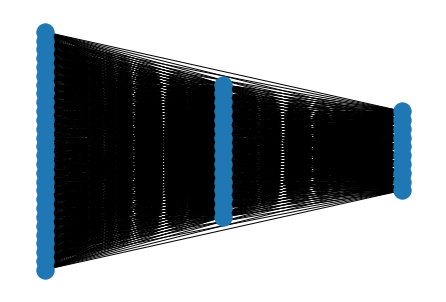

In [72]:
G = nx.complete_multipartite_graph(28, 16, 10)
pos = nx.multipartite_layout(G)


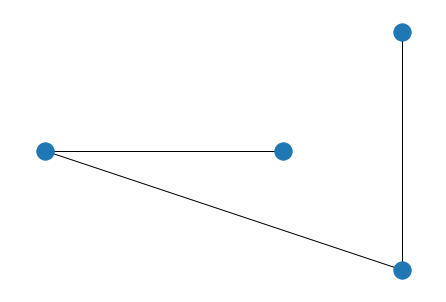

In [74]:
G = nx.path_graph(4)
shells = [[0], [1, 2, 3]]
pos = nx.shell_layout(G, shells)
nx.draw(G, pos=pos)

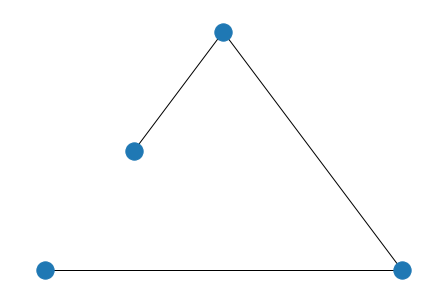

In [77]:
G = nx.path_graph(4)
pos = nx.planar_layout(G)
nx.draw(G, pos=pos)

In [83]:
G = nx.complete_graph(4)
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
nx.draw(G, pos=pos)

FileNotFoundError: [WinError 2] "neato" not found in path.

In [86]:
import networkx as nx
import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout


G = nx.DiGraph()
G.add_node(1,level=1)
G.add_node(2,level=2)
G.add_node(3,level=2)
G.add_node(4,level=3)

G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(2,4)

nx.draw(G, pos=graphviz_layout(G), node_size=1600, cmap=plt.cm.Blues,
        node_color=range(len(G)),
        prog='dot')
plt.show()

ImportError: requires pygraphviz http://pygraphviz.github.io/